In [38]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

churn_labels=pd.read_csv('churn_labels.csv')
users=pd.read_csv('users (1).csv',parse_dates=['signup_date'])
events=pd.read_csv('events (1).csv',parse_dates=['event_date'])
logins=pd.read_csv('logins.csv',parse_dates=['login_date'])
purchases=pd.read_csv('purchases.csv')

In [9]:
churn_labels['churn_date'] = pd.to_datetime(churn_labels['churn_date'])
churn_labels

,user_id,churned,churn_date
0,1,0,NaT
1,2,0,NaT
2,3,0,NaT
3,4,1,2024-08-01
4,5,0,NaT
...,...,...,...
14995,14996,0,NaT
14996,14997,1,2024-05-22
14997,14998,1,2024-09-09
14998,14999,0,NaT


In [10]:
users

,user_id,signup_date,country,device_type,marketing_channel,plan_type,last_login,days_since_last_login,churn_prob,churned,churn_date
0,1,2025-05-19,IN,Android,organic,standard,2025-09-27,3,0.106,1,1.761523e+18
1,2,2024-11-19,BR,Android,paid_ads,free,2025-07-23,69,0.388,1,1.757030e+18
2,3,2024-07-30,JP,Web,paid_ads,standard,2025-08-09,52,0.254,0,NaN
3,4,2024-06-09,US,Android,email,standard,2025-08-30,31,0.162,0,NaN
4,5,2025-05-19,US,Android,organic,free,2025-09-22,8,0.216,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14995,14996,2025-04-15,JP,Android,email,free,2025-08-18,43,0.286,0,NaN
14996,14997,2024-02-24,CN,iOS,paid_ads,free,2024-11-12,322,0.894,1,1.735430e+18
14997,14998,2024-08-25,JP,iOS,organic,free,2025-07-08,84,0.368,1,1.757030e+18
14998,14999,2024-09-07,US,iOS,email,free,2025-08-05,56,0.312,0,NaN


In [11]:
users

,user_id,signup_date,country,device_type,marketing_channel,plan_type,last_login,days_since_last_login,churn_prob,churned,churn_date
0,1,2025-05-19,IN,Android,organic,standard,2025-09-27,3,0.106,1,1.761523e+18
1,2,2024-11-19,BR,Android,paid_ads,free,2025-07-23,69,0.388,1,1.757030e+18
2,3,2024-07-30,JP,Web,paid_ads,standard,2025-08-09,52,0.254,0,NaN
3,4,2024-06-09,US,Android,email,standard,2025-08-30,31,0.162,0,NaN
4,5,2025-05-19,US,Android,organic,free,2025-09-22,8,0.216,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14995,14996,2025-04-15,JP,Android,email,free,2025-08-18,43,0.286,0,NaN
14996,14997,2024-02-24,CN,iOS,paid_ads,free,2024-11-12,322,0.894,1,1.735430e+18
14997,14998,2024-08-25,JP,iOS,organic,free,2025-07-08,84,0.368,1,1.757030e+18
14998,14999,2024-09-07,US,iOS,email,free,2025-08-05,56,0.312,0,NaN


In [12]:
import pandas as pd
import numpy as np

def compute_cohort_retention(users, logins, max_days=60):
    # 确保日期为 datetime 类型
    users["signup_date"] = pd.to_datetime(users["signup_date"])
    logins["login_date"] = pd.to_datetime(logins["login_date"])

    # 计算注册周
    users["signup_week"] = users["signup_date"].dt.to_period("W").apply(lambda r: r.start_time)

    # 合并登录数据
    df = logins.merge(users[["user_id", "signup_date", "signup_week"]], on="user_id", how="left")

    # 计算登录距注册天数
    df["days_after_signup"] = (df["login_date"].dt.floor("D") - df["signup_date"].dt.floor("D")).dt.days
    df = df[(df["days_after_signup"] >= 0) & (df["days_after_signup"] <= max_days)]

    # 每个用户每天唯一登录记录
    df_unique = df.drop_duplicates(subset=["user_id", "days_after_signup"])
    
    # 每个 cohort 在不同天的活跃人数
    cohort_data = (
        df_unique.groupby(["signup_week", "days_after_signup"])["user_id"]
        .nunique()
        .reset_index()
    )

    # cohort 总注册人数（分母）
    cohort_size = users.groupby("signup_week")["user_id"].nunique()

    # 构建矩阵
    cohort_matrix = cohort_data.pivot(index="signup_week", columns="days_after_signup", values="user_id")
    cohort_matrix = cohort_matrix.fillna(0).reindex(cohort_size.index)

    # 计算留存率（基于注册人数）
    cohort_matrix = cohort_matrix.div(cohort_size, axis=0) * 100

    # 固定 day0 = 100%
    cohort_matrix[0] = 100.0

    return cohort_matrix.round(1)

In [13]:
cohort_matrix = compute_cohort_retention(users, logins, max_days=60)
print(cohort_matrix.head(10).iloc[:, :15])  # 查看前15天

days_after_signup     0     1     2     3     4     5     6     7     8   \
signup_week                                                                
2024-01-01         100.0  37.0  34.3  36.1  37.5  38.4  32.9  31.9  31.0   
2024-01-08         100.0  36.2  39.8  32.7  38.8  36.2  34.2  34.2  31.6   
2024-01-15         100.0  44.4  40.3  38.4  43.1  43.5  40.7  37.0  41.2   
2024-01-22         100.0  38.6  42.4  39.7  38.6  34.2  38.0  37.5  37.0   
2024-01-29         100.0  36.3  36.8  39.4  38.9  34.2  37.3  31.1  30.1   
2024-02-05         100.0  35.9  35.9  37.9  39.3  38.8  36.9  34.5  31.1   
2024-02-12         100.0  43.3  42.2  42.2  36.9  37.4  40.1  40.6  38.0   
2024-02-19         100.0  39.2  38.0  38.0  35.7  37.4  34.5  41.5  28.7   
2024-02-26         100.0  41.7  39.8  42.2  43.1  42.2  43.6  41.7  40.3   
2024-03-04         100.0  43.9  39.4  40.3  42.5  42.1  42.5  37.1  43.9   

days_after_signup    9     10    11    12    13    14  
signup_week                    

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [15]:
cohort_matrix.head()

days_after_signup,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
signup_week,,,,,,,,,,,,,,,,,,,,,
2024-01-01,100.0,37.0,34.3,36.1,37.5,38.4,32.9,31.9,31.0,31.5,...,17.1,14.8,14.4,13.9,13.9,13.9,12.5,12.5,10.2,9.3
2024-01-08,100.0,36.2,39.8,32.7,38.8,36.2,34.2,34.2,31.6,27.0,...,11.2,14.3,11.7,11.2,11.2,10.2,9.7,11.7,11.7,10.2
2024-01-15,100.0,44.4,40.3,38.4,43.1,43.5,40.7,37.0,41.2,38.9,...,15.7,16.7,13.4,13.4,13.4,13.9,14.4,13.9,13.4,14.4
2024-01-22,100.0,38.6,42.4,39.7,38.6,34.2,38.0,37.5,37.0,31.0,...,14.1,13.0,13.6,19.0,15.2,16.8,13.0,13.0,12.5,19.0
2024-01-29,100.0,36.3,36.8,39.4,38.9,34.2,37.3,31.1,30.1,34.7,...,13.0,8.3,11.9,11.9,9.8,7.8,11.9,9.3,13.5,9.3


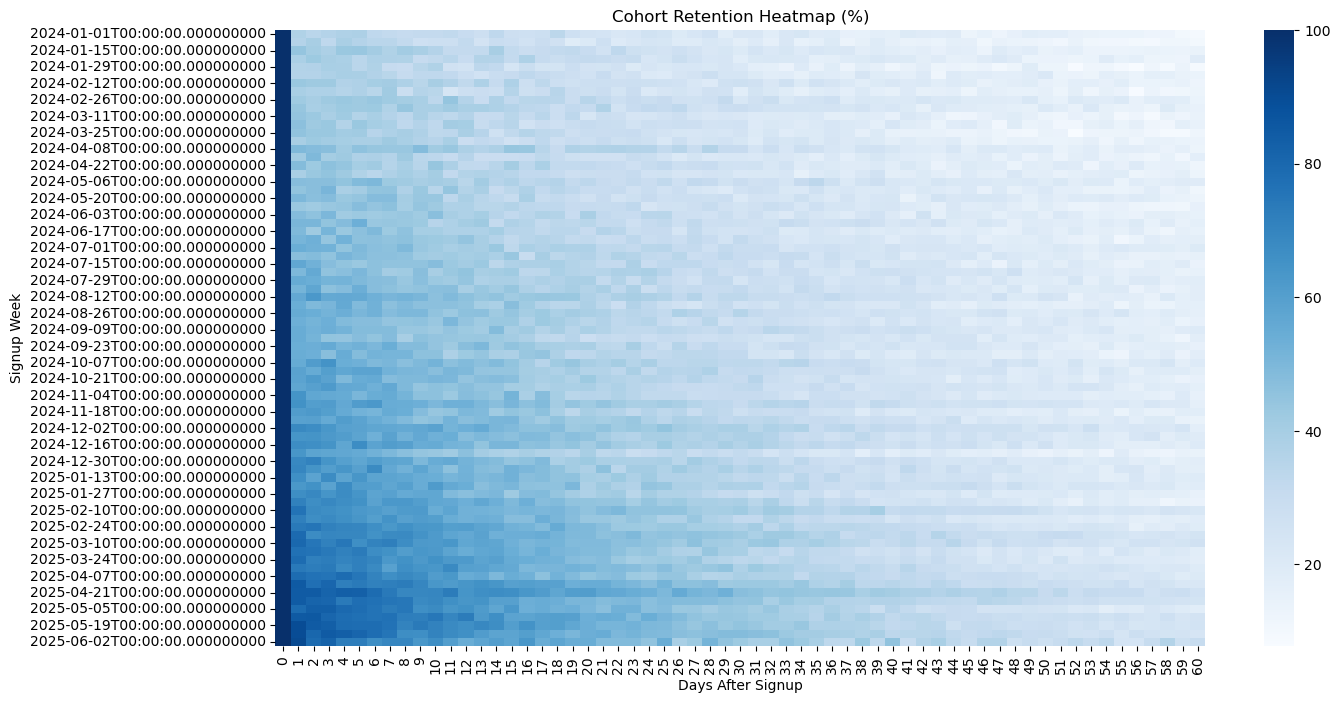

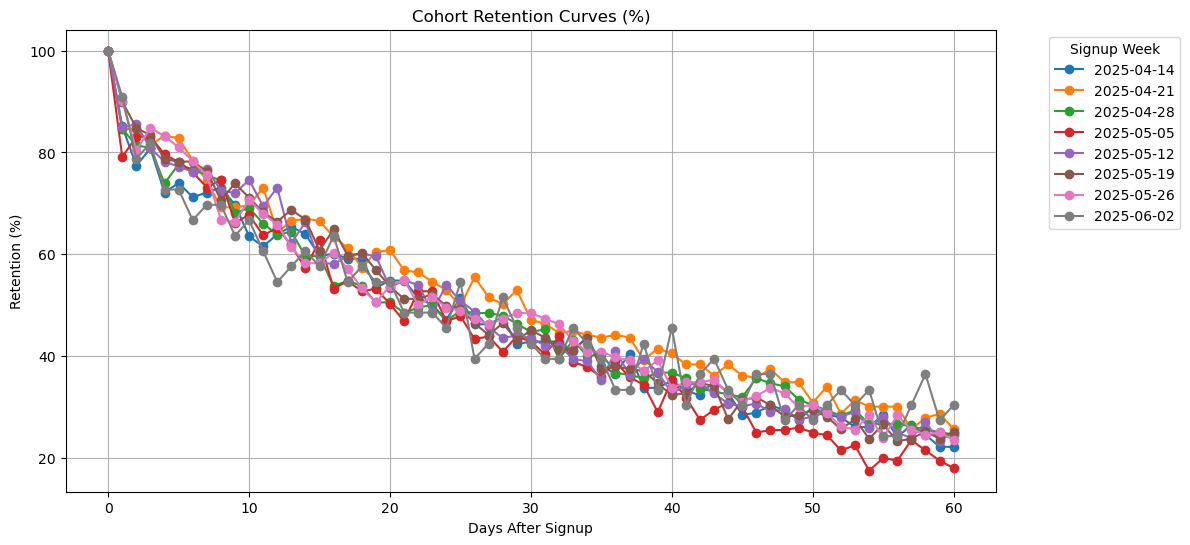

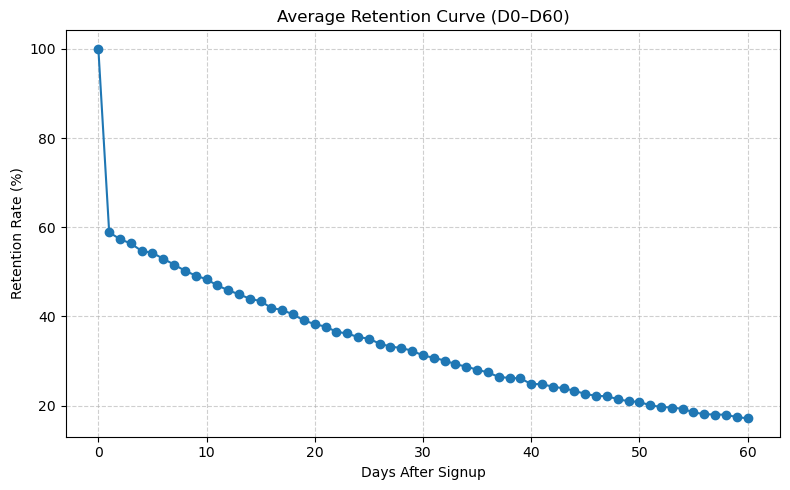

In [16]:
# 绘制热力图
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_matrix, cmap='Blues', annot=False, fmt=".1f")
plt.title("Cohort Retention Heatmap (%)")
plt.ylabel("Signup Week")
plt.xlabel("Days After Signup")
plt.show()

# 绘制留存曲线（最近 8 个 cohort）
recent_cohorts = cohort_matrix.tail(8).T  # 转置方便绘制
plt.figure(figsize=(12, 6))
for col in recent_cohorts.columns:
    plt.plot(recent_cohorts.index, recent_cohorts[col], marker='o', label=str(col.date()))
plt.title("Cohort Retention Curves (%)")
plt.xlabel("Days After Signup")
plt.ylabel("Retention (%)")
plt.legend(title='Signup Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 留存曲线（平均留存）

avg_retention = cohort_matrix.mean(axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_retention.index, avg_retention.values, marker="o")
plt.title("Average Retention Curve (D0–D60)")
plt.xlabel("Days After Signup")
plt.ylabel("Retention Rate (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()

In [51]:
users = pd.read_csv("users.csv", parse_dates=["signup_date"])
logins = pd.read_csv("logins.csv", parse_dates=["login_date"])

cohort_matrix = compute_cohort_retention(users, logins, max_days=60)


print(cohort_matrix.head())

days_after_signup         0          1          2          3          4   \
signup_week                                                                
2024-01-01         41.447368  30.263158  42.763158  36.184211  34.210526   
2024-01-08         34.090909  30.303030  32.575758  31.060606  30.303030   
2024-01-15         45.689655  43.103448  39.655172  35.344828  32.758621   
2024-01-22         38.759690  33.333333  35.658915  26.356589  36.434109   
2024-01-29         35.156250  39.843750  28.906250  32.812500  31.250000   

days_after_signup         5          6          7          8          9   ...  \
signup_week                                                               ...   
2024-01-01         34.868421  26.315789  30.921053  26.315789  24.342105  ...   
2024-01-08         28.030303  22.727273  26.515152  15.909091  23.484848  ...   
2024-01-15         35.344828  26.724138  29.310345  32.758621  27.586207  ...   
2024-01-22         31.007752  28.682171  27.906977  34.108527 

In [17]:
def cohort_retention_analysis(logins: pd.DataFrame, users: pd.DataFrame,
                                    group_cols: list = ['plan_type'],
                                    max_days: int = 30,
                                    plot: bool = True):

    # 1️⃣ 准备合并列：仅取 users 里确实存在的列
    user_cols = ['user_id', 'signup_date'] + [c for c in group_cols if c in users.columns]
    logins_ = logins.merge(users[user_cols], on='user_id', how='left')

    # 2️⃣ 如果 group_col 在 logins 而不在 users，也保留 logins 自己的那列
    for c in group_cols:
        if c not in logins_.columns and c in logins.columns:
            logins_[c] = logins[c]

    # 3️⃣ 计算 days_after_signup
    logins_['days_after_signup'] = (
        (logins_['login_date'].dt.floor('D') - logins_['signup_date'].dt.floor('D')).dt.days
    )
    logins_ = logins_[logins_['days_after_signup'] >= 0]

    all_retention = []
    # 4️⃣ 按 group_cols 计算留存
    for grp_vals, grp_df in logins_.groupby(group_cols):
        if isinstance(grp_vals, tuple):
            grp_dict = dict(zip(group_cols, grp_vals))
        else:
            grp_dict = {group_cols[0]: grp_vals}

        # 获取对应用户子集
        users_sub = users.copy()
        for col, val in grp_dict.items():
            if col in users_sub.columns:
                users_sub = users_sub[users_sub[col] == val]

        # 留存计算
        cohort_counts = (
            grp_df.groupby('days_after_signup')['user_id']
            .nunique()
            .reindex(range(0, max_days + 1), fill_value=0)
        )
        cohort_pct = cohort_counts / max(len(users_sub), 1) * 100

        df_temp = pd.DataFrame({
            **grp_dict,
            'day': cohort_pct.index,
            'retention_rate': cohort_pct.values
        })
        all_retention.append(df_temp)

    retention_df = pd.concat(all_retention, ignore_index=True)
    # 5️⃣ 绘图
    if plot:
        plt.figure(figsize=(10, 5))
        if len(group_cols) == 1:
            sns.lineplot(data=retention_df, x='day', y='retention_rate', hue=group_cols[0])
        else:
            retention_df['group'] = retention_df[group_cols].astype(str).agg('-'.join, axis=1)
            sns.lineplot(data=retention_df, x='day', y='retention_rate', hue='group')
        plt.title("Retention Curve")
        plt.xlabel("Days After Signup")
        plt.ylabel("Retention Rate (%)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return retention_df

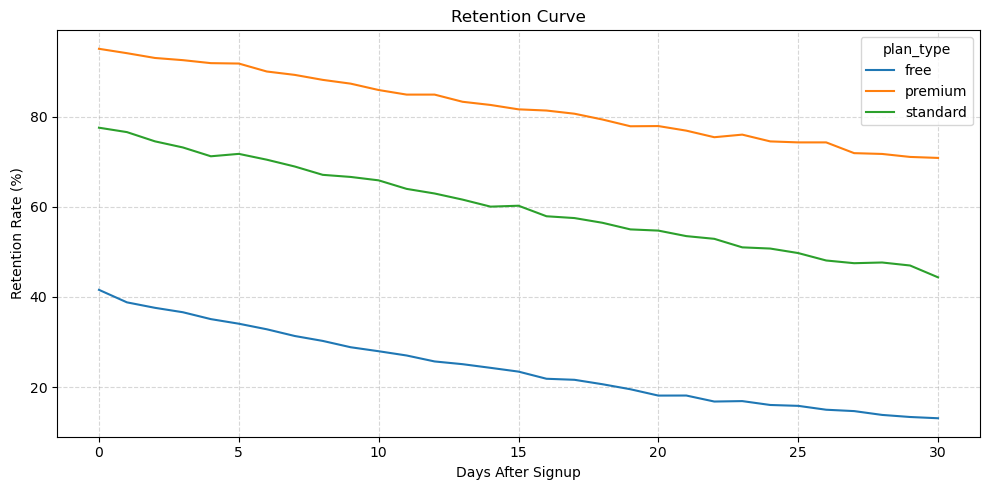

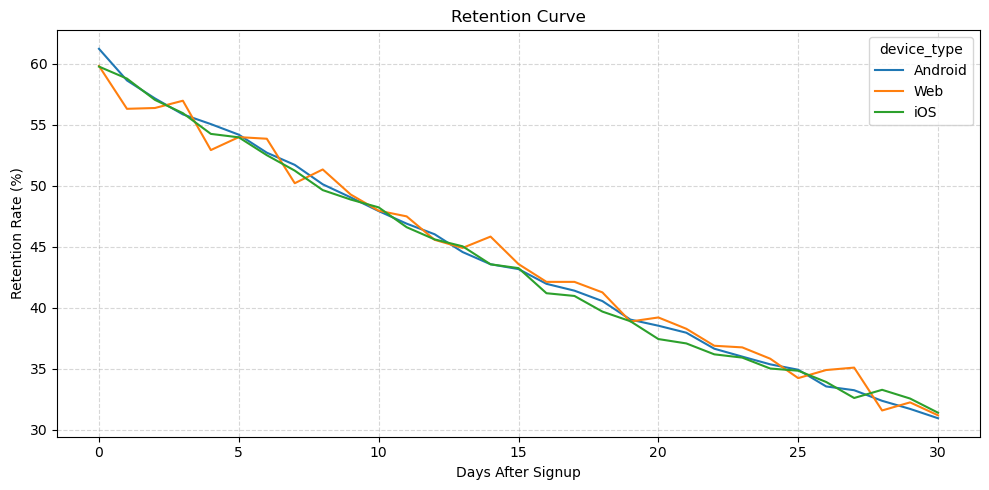

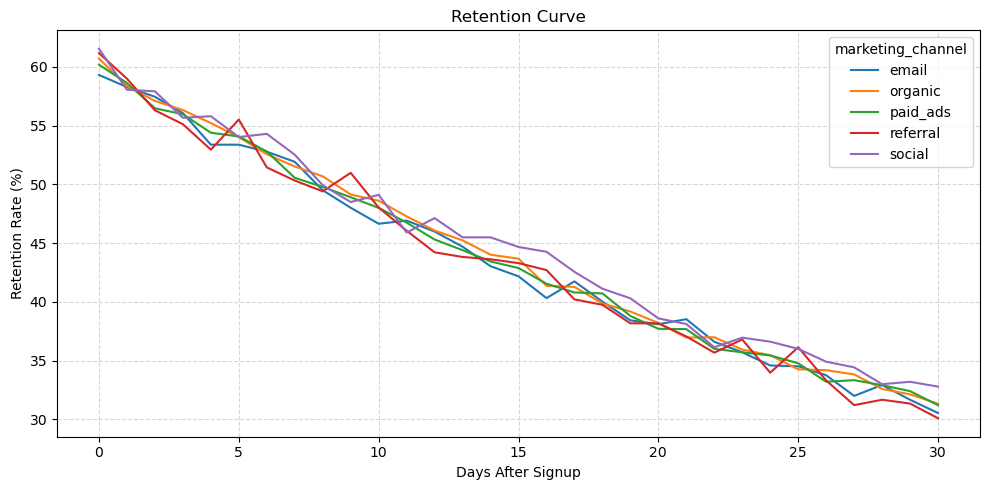

In [18]:
ret_plan = cohort_retention_analysis(logins, users, group_cols=['plan_type'], max_days=30)
ret_device = cohort_retention_analysis(logins, users, group_cols=['device_type'], max_days=30)
ret_channel = cohort_retention_analysis(logins, users, group_cols=['marketing_channel'], max_days=30)

Text(0.5, 1.0, 'Country Distribution')

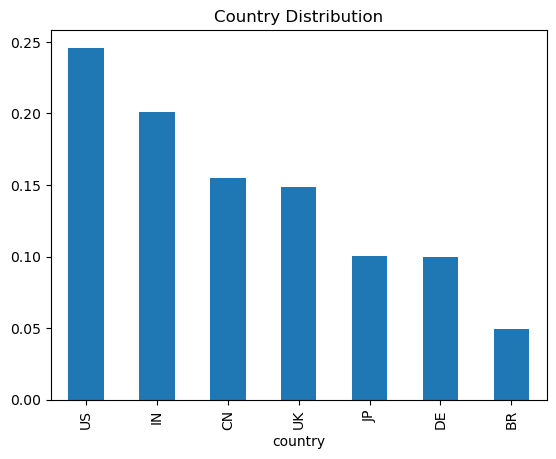

In [19]:
##用户结构 User Demographics EDA

users['country'].value_counts(normalize=True).plot(kind='bar')
plt.title("Country Distribution")

Text(0.5, 1.0, 'Device Type vs Plan Type')

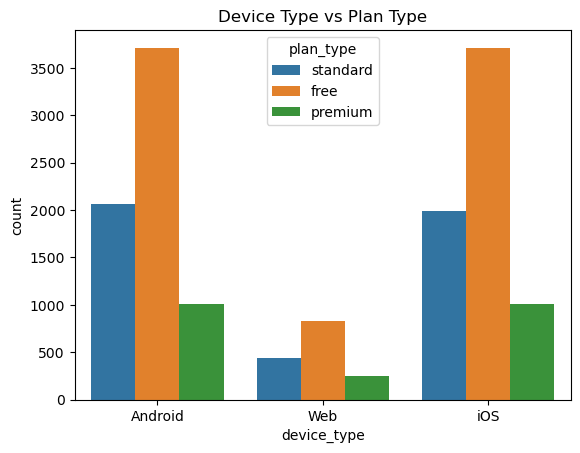

In [20]:
sns.countplot(data=users, x='device_type', hue='plan_type')
plt.title("Device Type vs Plan Type")

Text(0.5, 1.0, 'User Acquisition by Channel')

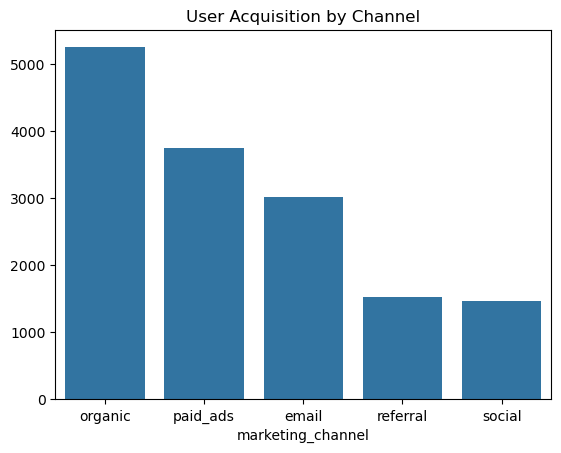

In [21]:
channel_summary = users['marketing_channel'].value_counts()
sns.barplot(x=channel_summary.index, y=channel_summary.values)
plt.title("User Acquisition by Channel")

Text(0.5, 1.0, 'Average Purchase Amount by Country')

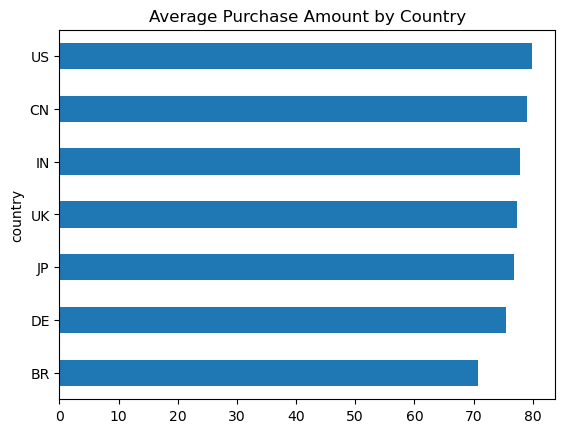

In [22]:
purchases.merge(users, on='user_id').groupby('country')['amount'].mean().sort_values().plot(kind='barh')
plt.title("Average Purchase Amount by Country")

Text(0.5, 1.0, 'Daily Active Users (DAU)')

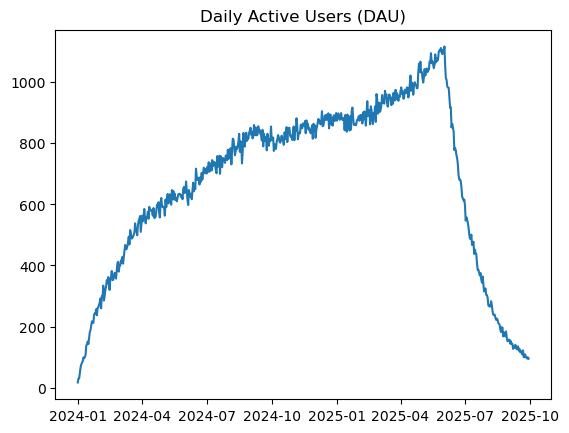

In [23]:
##留存 & 活跃（Retention & Engagement） EDA

logins['date'] = logins['login_date'].dt.date
dau = logins.groupby('date')['user_id'].nunique()
plt.plot(dau.index, dau.values)
plt.title("Daily Active Users (DAU)")

Text(0.5, 1.0, 'Daily Active Rate (%)')

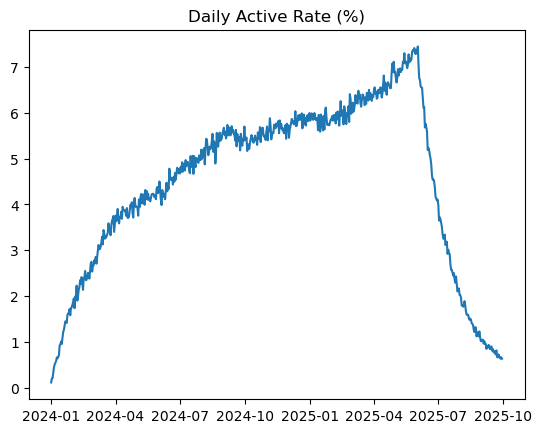

In [24]:
active_rate = (dau / len(users)) * 100
plt.plot(active_rate)
plt.title("Daily Active Rate (%)")

In [25]:
##付费行为（Revenue & Monetization）

purchases.merge(users, on='user_id').groupby('plan_type')['amount'].mean()

plan_type
free         14.864068
premium     118.313727
standard     50.086229
Name: amount, dtype: float64

<Axes: title={'center': 'Cumulative Revenue Over Time'}, xlabel='purchase_date'>

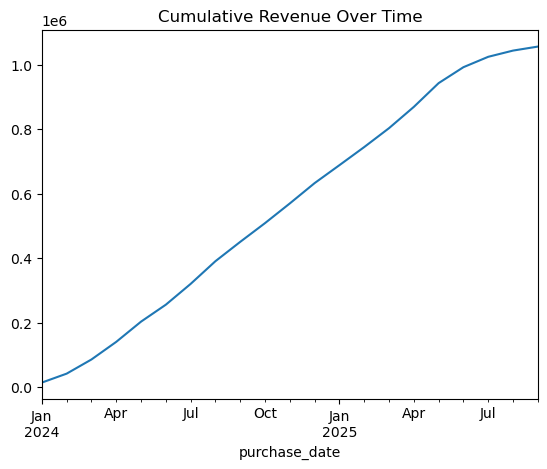

In [26]:
purchases['purchase_date'] = pd.to_datetime(purchases['purchase_date'])
ltv = purchases.groupby(purchases['purchase_date'].dt.to_period('M'))['amount'].sum().cumsum()
ltv.plot(title='Cumulative Revenue Over Time')

Text(0.5, 1.0, 'Discount Usage vs Upgrade')

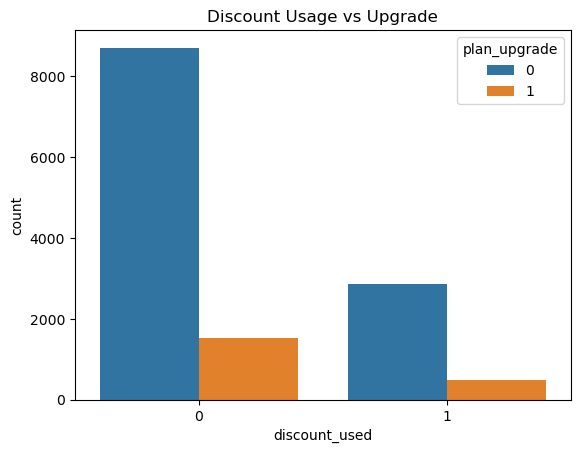

In [27]:
sns.countplot(data=purchases, x='discount_used', hue='plan_upgrade')
plt.title("Discount Usage vs Upgrade")

##Discount usage还有提升空间

([0, 1, 2, 3, 4],
 [Text(0, 0, 'view'),
  Text(1, 0, 'search'),
  Text(2, 0, 'feature_use'),
  Text(3, 0, 'share'),
  Text(4, 0, 'comment')])

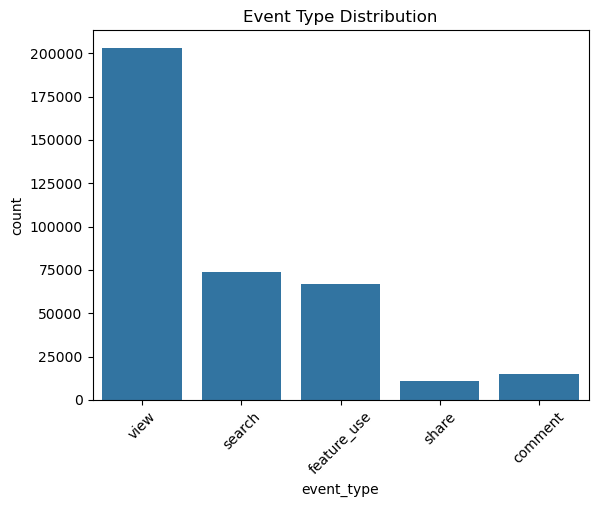

In [28]:
## 事件行为（Event Analysis）
sns.countplot(data=events, x='event_type')
plt.title("Event Type Distribution")
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Event Volume Over Time')

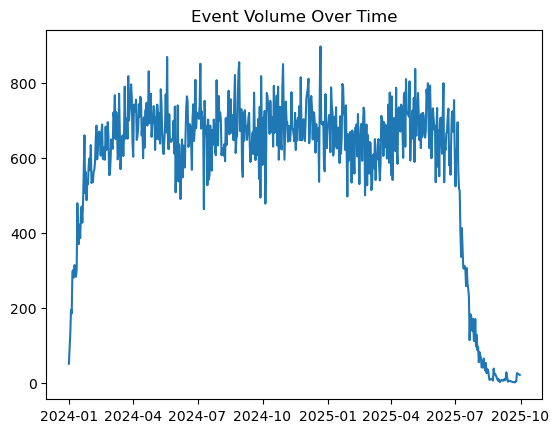

In [33]:
daily_events = events.groupby(events['event_date'].dt.date)['event_type'].count()
plt.plot(daily_events)
plt.title("Event Volume Over Time")

##2025/6 peak cause?  What events lead to the peak or low

Text(0.5, 1.0, 'Event Count per User Distribution')

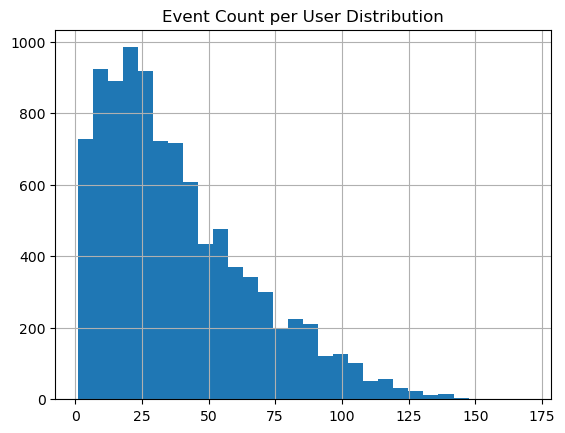

In [34]:
events.groupby('user_id')['event_type'].count().hist(bins=30)
plt.title("Event Count per User Distribution")

In [39]:
events.head()

,user_id,event_date,event_type,event_value
0,1,2025-09-26,feature_use,4.039602
1,1,2025-09-26,upgrade_page,1.333980
2,1,2025-06-05,view,1.881738
3,1,2025-06-05,click,7.399672
4,1,2025-06-05,view,6.050969


Text(0.5, 1.0, 'Feature Usage by Plan Type')

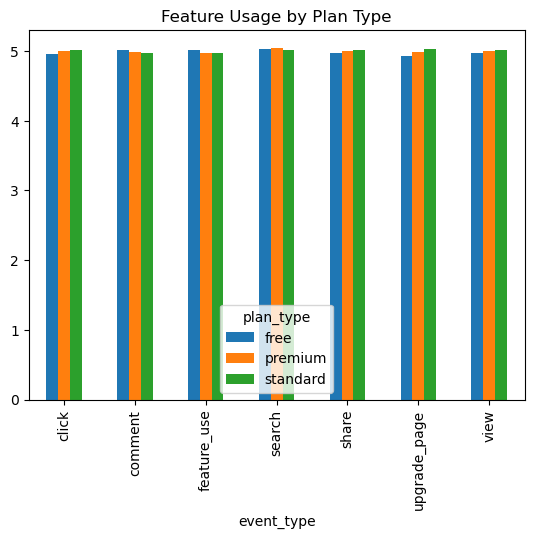

In [40]:
events.merge(users, on='user_id').pivot_table(
    index='event_type', columns='plan_type', values='event_value', aggfunc='mean'
).plot(kind='bar')
plt.title("Feature Usage by Plan Type")

## feature use, search, comment, free占比多

In [41]:
users['churned'].value_counts(normalize=True)

churned
0    0.7344
1    0.2656
Name: proportion, dtype: float64

In [42]:
users.groupby('plan_type')['churned'].mean().sort_values()

plan_type
premium     0.087091
standard    0.187263
free        0.357221
Name: churned, dtype: float64

In [43]:
users.groupby('marketing_channel')['churned'].mean().sort_values()

marketing_channel
organic     0.247332
email       0.249668
referral    0.257556
social      0.258880
paid_ads    0.309867
Name: churned, dtype: float64

In [44]:
logins.merge(users[['user_id','churned']], on='user_id') \
    .groupby('churned')['session_length'].mean()

churned
0    31.944724
1    31.956817
Name: session_length, dtype: float64

<Axes: >

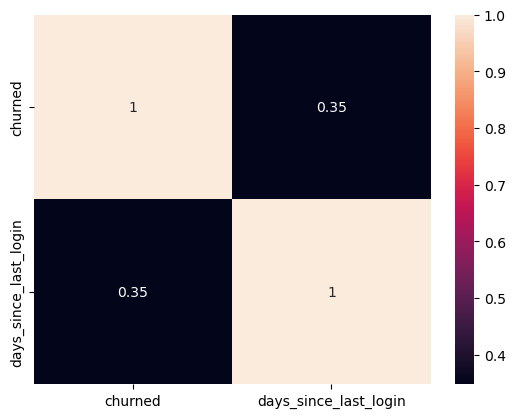

In [45]:
import seaborn as sns
corr = users[['churned','days_since_last_login']].corr()
sns.heatmap(corr, annot=True)

In [46]:
## Churn Prediction Data Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

In [47]:
sns.set(style="whitegrid")

In [49]:
### logistic, random forest, lightGBM---compare performance

# 1) Load Datasets

users = pd.read_csv('users (1).csv', parse_dates=["signup_date"], infer_datetime_format=True)
logins = pd.read_csv("logins.csv", parse_dates=["login_date"], infer_datetime_format=True)
events = pd.read_csv('events (1).csv', parse_dates=["event_date"], infer_datetime_format=True)
purchases = pd.read_csv("purchases.csv", parse_dates=["purchase_date"], infer_datetime_format=True)
try:
    churn = pd.read_csv("churn_labels.csv", parse_dates=["churn_date"], infer_datetime_format=True)
except FileNotFoundError:
    churn = pd.DataFrame(columns=["user_id", "churned", "churn_date"])

/tmp/ipykernel_732/3066187659.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  users = pd.read_csv('users (1).csv', parse_dates=["signup_date"], infer_datetime_format=True)
/tmp/ipykernel_732/3066187659.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  logins = pd.read_csv("logins.csv", parse_dates=["login_date"], infer_datetime_format=True)
/tmp/ipykernel_732/3066187659.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pyda

In [50]:
# 2) Ensure types and merge churn into users (prefer churn file if present)

users["user_id"] = users["user_id"].astype(int)
logins["user_id"] = logins["user_id"].astype(int)
events["user_id"] = events["user_id"].astype(int)
purchases["user_id"] = purchases["user_id"].astype(int)

if "user_id" in churn.columns:
    churn["user_id"] = churn["user_id"].astype(int)

# merge churn into users, but keep existing users columns (use suffixes to detect later)
users = users.merge(churn, on="user_id", how="left", suffixes=("", "_churnfile"))
# If churn info already in users (from earlier), unify: prefer churn (from churn file) if present, else keep original
if "churned" in users.columns and "churned_churnfile" in users.columns:
    users["churned"] = users["churned_churnfile"].fillna(users["churned"])
    users.drop(columns=["churned_churnfile"], inplace=True)
if "churn_date" in users.columns and "churn_date_churnfile" in users.columns:
    users["churn_date"] = users["churn_date_churnfile"].fillna(users["churn_date"])
    users.drop(columns=["churn_date_churnfile"], inplace=True)

# If churn still missing, create default 0 column
if "churned" not in users.columns:
    users["churned"] = 0
else:
    users["churned"] = users["churned"].fillna(0).astype(int)

In [52]:
# 3) Feature engineering

# LOGIN features
login_agg = (
    logins.groupby("user_id")
    .agg(
        login_count=("login_date", "count"),
        active_days=("login_date", lambda x: x.dt.date.nunique()),
        last_login=("login_date", "max"),
        avg_session_len=("session_length", "mean")
    )
    .reset_index()
)
# days since last login relative to dataset end (fallback to signup if no last_login)
dataset_end = max(logins["login_date"].max(), users["signup_date"].max()) if not logins.empty else users["signup_date"].max()
login_agg["last_login"] = pd.to_datetime(login_agg["last_login"])
# -----------------------------
# 计算 days_since_last_login 
# -----------------------------
# 强制转换日期类型
users["signup_date"] = pd.to_datetime(users["signup_date"], errors="coerce")
login_agg["last_login"] = pd.to_datetime(login_agg["last_login"], errors="coerce")
# 定义数据集截止日期（可理解为分析时点）
dataset_end = pd.to_datetime(
    max(
        [d for d in [logins["login_date"].max(), users["signup_date"].max()] if pd.notnull(d)]
    )
)

# 如果 last_login 是 NaT，用 signup_date 填充
login_agg = login_agg.merge(
    users[["user_id", "signup_date"]], on="user_id", how="left"
)
login_agg["last_login_filled"] = login_agg["last_login"].fillna(login_agg["signup_date"])

# 计算距最后登录的天数
login_agg["days_since_last_login"] = (
    (dataset_end - login_agg["last_login_filled"]).dt.days
)

# 删除辅助列
login_agg.drop(columns=["last_login_filled"], inplace=True)

# PURCHASE features
purchase_agg = (
    purchases.groupby("user_id")
    .agg(
        total_spent=("amount", "sum"),
        num_purchases=("amount", "count"),
        avg_purchase=("amount", "mean"),
        upgrades=("plan_upgrade", "sum"),
        discount_used=("discount_used", "mean")
    )
    .reset_index()
)
# EVENT features
event_agg = (
    events.groupby("user_id")
    .agg(
        num_events=("event_type", "count"),
        unique_events=("event_type", "nunique"),
        avg_event_value=("event_value", "mean")
    )
    .reset_index()
)

In [54]:
# 4) Combine features into one DataFrame

features = users.merge(login_agg, on="user_id", how="left")
features = features.merge(purchase_agg, on="user_id", how="left")
features = features.merge(event_agg, on="user_id", how="left")
# fill NaN with sensible defaults
fill_defaults = {
    "login_count": 0,
    "active_days": 0,
    "avg_session_len": 0,
    "days_since_last_login": (dataset_end - users["signup_date"]).dt.days,
    "total_spent": 0,
    "num_purchases": 0,
    "avg_purchase": 0,
    "upgrades": 0,
    "discount_used": 0,
    "num_events": 0,
    "unique_events": 0,
    "avg_event_value": 0
}
for c, v in fill_defaults.items():
    if c in features.columns:
        features[c] = features[c].fillna(v)

features

,user_id,signup_date_x,country,device_type,marketing_channel,plan_type,last_login_x,days_since_last_login_x,churn_prob,churned,...,signup_date_y,days_since_last_login_y,total_spent,num_purchases,avg_purchase,upgrades,discount_used,num_events,unique_events,avg_event_value
0,1,2025-05-19,IN,Android,organic,standard,2025-09-27,3,0.106,0,...,2025-05-19,72.0,0.00,0.0,0.00,0.0,0.0,36.0,7.0,4.130724
1,2,2024-11-19,BR,Android,paid_ads,free,2025-07-23,69,0.388,0,...,2024-11-19,194.0,0.00,0.0,0.00,0.0,0.0,15.0,4.0,3.529649
2,3,2024-07-30,JP,Web,paid_ads,standard,2025-08-09,52,0.254,0,...,2024-07-30,282.0,0.00,0.0,0.00,0.0,0.0,40.0,6.0,5.047471
3,4,2024-06-09,US,Android,email,standard,2025-08-30,31,0.162,1,...,2024-06-09,435.0,46.32,1.0,46.32,1.0,0.0,34.0,7.0,4.927012
4,5,2025-05-19,US,Android,organic,free,2025-09-22,8,0.216,0,...,2025-05-19,81.0,0.00,0.0,0.00,0.0,0.0,18.0,5.0,4.558414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14996,2025-04-15,JP,Android,email,free,2025-08-18,43,0.286,0,...,2025-04-15,143.0,0.83,1.0,0.83,0.0,0.0,12.0,5.0,6.507740
14996,14997,2024-02-24,CN,iOS,paid_ads,free,2024-11-12,322,0.894,1,...,2024-02-24,511.0,3.96,1.0,3.96,1.0,0.0,15.0,7.0,5.479641
14997,14998,2024-08-25,JP,iOS,organic,free,2025-07-08,84,0.368,1,...,2024-08-25,400.0,18.13,1.0,18.13,0.0,0.0,4.0,4.0,6.982941
14998,14999,2024-09-07,US,iOS,email,free,2025-08-05,56,0.312,0,...,2024-09-07,315.0,0.00,0.0,0.00,0.0,0.0,17.0,5.0,4.456317


In [56]:
# 5) Clean duplicate / _x _y columns if merges accidentally created them

cols = features.columns.tolist()
# rename some common _y to base
for suffix in ["_y", "_churnfile"]:
    for col in cols:
        if col.endswith(suffix):
            base = col[:-len(suffix)]
            if base not in features.columns or pd.isnull(features.get(base)).all():
                features.rename(columns={col: base}, inplace=True)

# drop any remaining *_x columns
to_drop = [c for c in features.columns if c.endswith("_x")]
if to_drop:
    features.drop(columns=to_drop, inplace=True)

# final check: ensure churned exists
if "churned" not in features.columns:
    features["churned"] = users["churned"].fillna(0).astype(int)
else:
    features["churned"] = features["churned"].fillna(users["churned"].fillna(0)).astype(int)


features

,user_id,country,device_type,marketing_channel,plan_type,churn_prob,churned,churn_date,login_count,active_days,...,signup_date,days_since_last_login,total_spent,num_purchases,avg_purchase,upgrades,discount_used,num_events,unique_events,avg_event_value
0,1,IN,Android,organic,standard,0.106,0,1761523200000000000.0,52.0,52.0,...,2025-05-19,72.0,0.00,0.0,0.00,0.0,0.0,36.0,7.0,4.130724
1,2,BR,Android,paid_ads,free,0.388,0,1757030400000000000.0,23.0,23.0,...,2024-11-19,194.0,0.00,0.0,0.00,0.0,0.0,15.0,4.0,3.529649
2,3,JP,Web,paid_ads,standard,0.254,0,NaN,70.0,70.0,...,2024-07-30,282.0,0.00,0.0,0.00,0.0,0.0,40.0,6.0,5.047471
3,4,US,Android,email,standard,0.162,1,1722470400000000000,23.0,23.0,...,2024-06-09,435.0,46.32,1.0,46.32,1.0,0.0,34.0,7.0,4.927012
4,5,US,Android,organic,free,0.216,0,NaN,28.0,28.0,...,2025-05-19,81.0,0.00,0.0,0.00,0.0,0.0,18.0,5.0,4.558414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14996,JP,Android,email,free,0.286,0,NaN,16.0,16.0,...,2025-04-15,143.0,0.83,1.0,0.83,0.0,0.0,12.0,5.0,6.507740
14996,14997,CN,iOS,paid_ads,free,0.894,1,1716336000000000000,15.0,15.0,...,2024-02-24,511.0,3.96,1.0,3.96,1.0,0.0,15.0,7.0,5.479641
14997,14998,JP,iOS,organic,free,0.368,1,1725840000000000000,1.0,1.0,...,2024-08-25,400.0,18.13,1.0,18.13,0.0,0.0,4.0,4.0,6.982941
14998,14999,US,iOS,email,free,0.312,0,NaN,17.0,17.0,...,2024-09-07,315.0,0.00,0.0,0.00,0.0,0.0,17.0,5.0,4.456317


In [57]:
# 6) Prepare X, y

# choose categorical columns to one-hot encode
categorical_cols = [c for c in ["country", "device_type", "marketing_channel", "plan_type"] if c in features.columns]

# drop columns that should not be features
drop_cols = ["user_id", "signup_date", "churn_date", "last_login"]
drop_cols = [c for c in drop_cols if c in features.columns]

X_df = features.drop(columns=drop_cols + ["churned"], errors='ignore')
# One-hot encode categorical cols
X_encoded = pd.get_dummies(X_df, columns=categorical_cols, drop_first=True)

# y label
y = features["churned"].astype(int)

print("Feature matrix shape:", X_encoded.shape)
print("Label distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (15000, 27)
Label distribution:
 churned
1    0.685733
0    0.314267
Name: proportion, dtype: float64


In [58]:
# 7) Train / Test split and scaling

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.fillna(0))
X_test_scaled = scaler.transform(X_test.fillna(0))

In [59]:
# 8) Train Logistic Regression

model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)


ROC AUC on test: 0.8376

Classification report:
              precision    recall  f1-score   support

           0     0.5686    0.7674    0.6532      1178
           1     0.8731    0.7333    0.7971      2572

    accuracy                         0.7440      3750
   macro avg     0.7209    0.7503    0.7252      3750
weighted avg     0.7775    0.7440    0.7519      3750



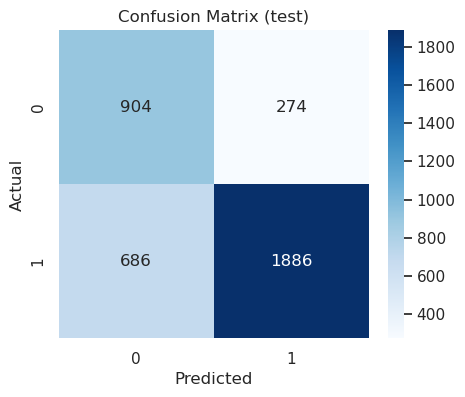

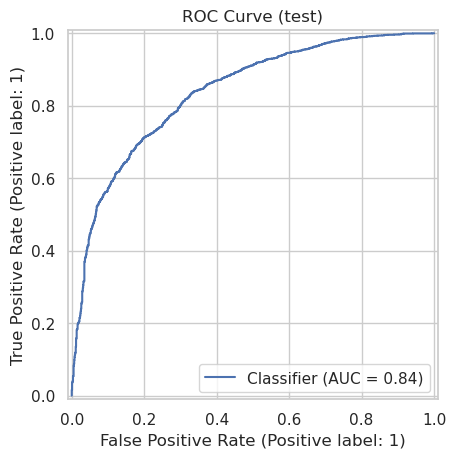

In [60]:
# 9) Evaluation

y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC on test: {auc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve (test)")
plt.show()

##0,7-0.8一般，0.8以上很好，0.9以上极佳；模型可以识别留存用户但是会有漏判情况；模型在识别流失用户上表现优秀（可能是因为流失用户占比达）

##模型预测流失的用户里，87.3%确实流失 (churned, precision); 实际上流失的用户中，73.4%的用户被模型识别出来了（churned, recall); 
## 79.72的F1_Score表示，模型在流失用户预测中表现很好


##不要错过要流失的用户（业务）--recall rate注重

##注重precision,不浪费留存资源；注重

##调整数据集的balance(oversampling, undersampling);调整模型的参数； 换其他的模型



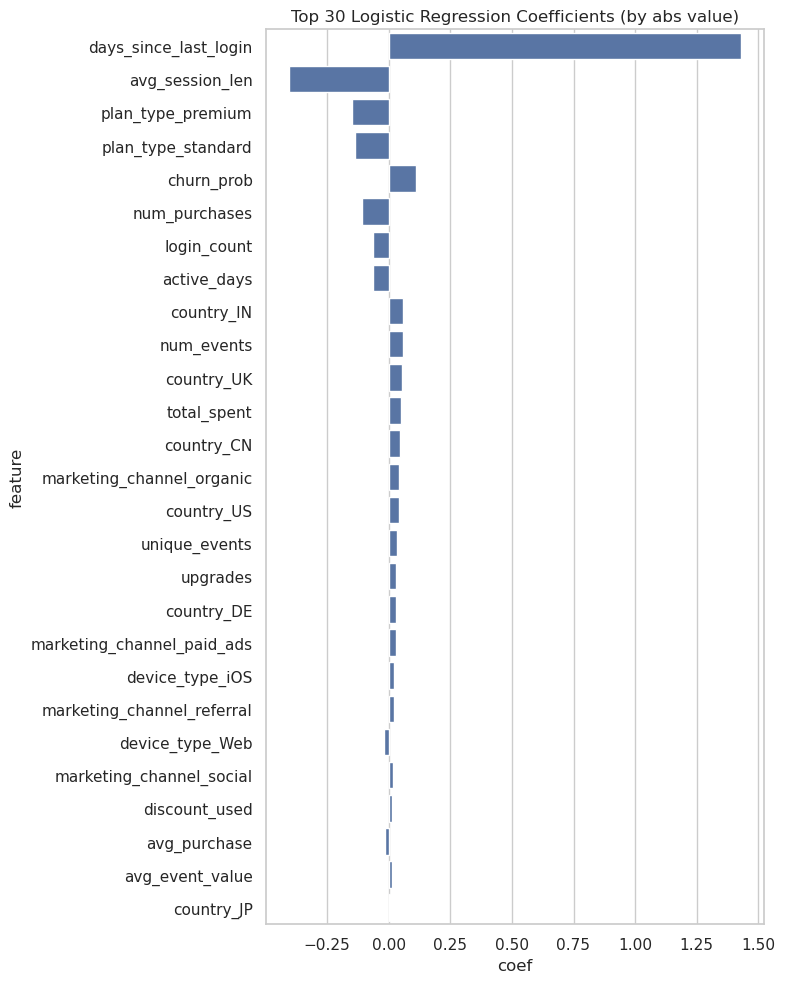

In [61]:
# 10) Feature importance (coefficients)

coef = model.coef_[0]
feat_names = X_encoded.columns
coef_df = pd.DataFrame({"feature": feat_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Top 30 Logistic Regression Coefficients (by abs value)")
plt.tight_layout()
plt.show()